Considering the harmonic oscillator system: 
$$ \dot{y} = \begin{bmatrix}
           \dot{p} \\
           \dot{q} \\
         \end{bmatrix} = 
    \begin{bmatrix}
           q \\
           -p \\
         \end{bmatrix} = f(p,h)  $$

Using 1-dimentional discontinous Galerkin FEM. The discretization (per element) is given by
$$ 
\int_{I_n} (\dot{y_h} - f(p_h,q_h))\phi \ dt \ + \llbracket y_n\rrbracket \phi_n(t_j) = 0
$$ 
Ordering is chosen to let $y_h$ contain alternate elements of $p_h$ and $q_h$ such that the resulting linear system is block tridiagonal, i.e: 
$$
\begin{align}
y &= \begin{bmatrix} ... & y_n^- & y_n^+ & y_{n+1}^- & ...  \end{bmatrix} \\
  &= \begin{bmatrix} ... & p_n^- & q_n^- & p_n^+ & q_n^+ & p_{n+1}^- & q_{n+1}^- & ...  \end{bmatrix}
\end{align}
$$

In [10]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, lil_matrix, vstack, hstack, save_npz, load_npz
from scipy.sparse.linalg import spsolve

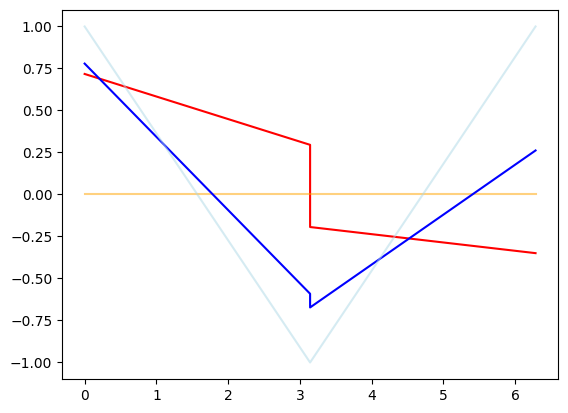

In [5]:
N = 2
dof = 4
T = 2*np.pi
h = T/N 
t = np.arange(0, T+h, h)
p_0 = 0
q_0 = 1

# p' = -q, q' = p
# main_block_matrix = np.array([
#     [0.5, h/3, 1/2, h/6], 
#     [-h/3, 0.5, -h/6, 1/2], 
#     [-0.5, h/6, 0.5, h/3],
#     [-h/6, -0.5, -h/3, 0.5]
#     ])

# p' = q, q' = -p
main_block_matrix = np.array([
    [0.5, -h/3, 1/2, -h/6], 
    [h/3, 0.5, h/6, 1/2], 
    [-0.5, -h/6, 0.5, -h/3],
    [h/6, -0.5, h/3, 0.5]
    ])

lower_block_matrix = np.zeros((dof, dof))
lower_block_matrix[0, -2] = -1
lower_block_matrix[1, -1] = -1
upper_block_matrix = np.zeros((dof, dof))

def construct_block_tridiagonal_matrix(A, B, C, N):
    """
    Construct a block-tridiagonal matrix in CSR format.
    
    Parameters:
    A: 4x4 array, lower block matrix
    B: 4x4 array, main block matrix
    C: 4x4 array, upper block matrix
    N: integer, number of blocks along one dimension
    
    Returns:
    CSR sparse matrix of size (4*N, 4*N)
    """
    dof = A.shape[0]  # This should be 4 since A, B, and C are 4x4

    # Initialize empty lists for blocks to construct block matrix
    blocks = []
    
    # Construct the first block row
    block_row = [csr_matrix(B)]  # The first block is B
    if N > 1:
        block_row.append(csr_matrix(C))  # Followed by C
    block_row.extend([csr_matrix((dof, dof))] * (N-2))  # Remaining blocks in this row are zero
    blocks.append(hstack(block_row))  # Stack horizontally to form the first row

    # Construct the inner block rows
    for i in range(1, N-1):
        block_row = [csr_matrix((dof, dof))] * (i-1)  # Start with (i-1) zero blocks
        block_row.append(csr_matrix(A))  # Add A to the sub-diagonal position
        block_row.append(csr_matrix(B))  # Add B to the main diagonal
        block_row.append(csr_matrix(C))  # Add C to the super-diagonal
        block_row.extend([csr_matrix((dof, dof))] * (N-i-2))  # Fill the rest with zero blocks
        blocks.append(hstack(block_row))  # Stack to form the row

    # Construct the last block row
    if N > 1:
        block_row = [csr_matrix((dof, dof))] * (N-2)  # First (N-2) blocks are zero
        block_row.append(csr_matrix(A))  # Then A
        block_row.append(csr_matrix(B))  # Finally B
        blocks.append(hstack(block_row))  # Stack to form the last row
    
    # Stack all rows vertically
    block_tridiagonal_matrix = vstack(blocks)

    return block_tridiagonal_matrix.tocsr()

def construct_rhs_vector(p_0, q_0, N, dof=4):
    """
    Construct a right-hand side (RHS) vector in CSR format.
    
    Parameters:
    p_0: scalar, first entry
    q_0: scalar, second entry
    N: integer, number of blocks
    dof: degrees of freedom per block (should be 4)
    
    Returns:
    Sparse CSR vector of size (4*N)
    """
    rhs = np.zeros(dof * N)
    rhs[0] = p_0  # First entry
    rhs[1] = q_0  # Second entry
    
    return csr_matrix(rhs).T

A = construct_block_tridiagonal_matrix(lower_block_matrix, main_block_matrix, upper_block_matrix, N)
f = construct_rhs_vector(p_0, q_0, N, dof)

y = spsolve(A, f)
p = y[::2]
q = y[1::2]

def plot_solution(t, u, true_solution, colors=['red', 'green']):
    tp = np.array([t[i:i+2] for i in range(0, N)]).flatten() # time points in each element
    U = np.array([u[i:i+2] for i in range(0, len(u), 2)]).flatten() # approximate solution in each element
    V = true_solution(tp) # true solution in each element
    plt.plot(tp, U, color=colors[0])
    plt.plot(tp, V, color=colors[1], alpha=0.5)

def solution_p(t):
    return np.sin(t)

def solution_q(t):
    return np.cos(t)

plot_solution(t, p, solution_p, colors=['red', 'orange'])
plot_solution(t, q, solution_q, colors=['blue', 'lightblue'])

In [107]:
# Define the 3x3 blocks
block_1 = np.random.randint(0, 10, (3, 3))
block_2 = np.random.randint(0, 10, (3, 3))
block_3 = np.random.randint(0, 10, (3, 3))
off_diag_1 = np.random.randint(0, 10, (3, 3))
off_diag_2 = np.random.randint(0, 10, (3, 3))

# Construct the 9x9 block tridiagonal matrix
A1 = np.block([
    [block_1, off_diag_1, np.zeros((3, 3))],
    [off_diag_1.T, block_2, off_diag_2],
    [np.zeros((3, 3)), off_diag_2.T, block_3]
])

f1 = np.arange(1, 10)

In [108]:
def cyclic_reduction_parallel(A, f, block_size, max_depth=3, depth=0):
    m, n = A.shape
    # if not isinstance(A, csr_matrix):
    #     A = csr_matrix(A)

    # Number of diagonal blocks for the given block size
    number_of_diagonal_blocks = m // block_size
    n_odd = number_of_diagonal_blocks // 2  # number of diagonal blocks with odd indices
    n_even = number_of_diagonal_blocks - n_odd  # number of diagonal blocks with even indices
    
    # if depth >= max_depth:
    #     return spsolve(A, f)
    
    B = np.zeros((m, n))
    g = np.zeros(m)

    # Even indices diagonal (process the even diagonal blocks first)
    for i in range(n_even):
        j = 2 * i
        B[block_size * n_odd + block_size * i:block_size * n_odd + block_size * (i + 1), block_size * n_odd + block_size * i:block_size * n_odd + block_size * (i + 1)] = A[j * block_size:(j + 1) * block_size, j * block_size:(j + 1) * block_size]
        g[block_size * n_odd + block_size * i:block_size * n_odd + block_size * (i + 1)] = f[j * block_size:(j + 1) * block_size]

    # Odd indices diagonal (process the odd diagonal blocks)
    for i in range(n_odd):
        j = 2 * i + 1
        B[block_size * i:block_size * (i + 1), block_size * i:block_size * (i + 1)] = A[j * block_size:(j + 1) * block_size, j * block_size:(j + 1) * block_size]
        g[block_size * i:block_size * (i + 1)] = f[j * block_size:(j + 1) * block_size]

    # Off-diagonal blocks, even indices (F_i)
    for i in range(n_odd):
        j = 2 * i
        B[block_size * n_odd + block_size * i:block_size * n_odd + block_size * (i + 1), block_size * i:block_size * (i + 1)] = A[j * block_size:(j + 1) * block_size, (j + 1) * block_size:(j + 2) * block_size]
    
    # Off-diagonal blocks, odd indices (F_i)
    for i in range(n_even - 1):
        j = 2 * i + 1
        B[block_size * i:block_size * (i + 1), block_size * n_odd + block_size * (i + 1):block_size * n_odd + block_size * (i + 2)] = A[j * block_size:(j + 1) * block_size, (j + 1) * block_size:(j + 2) * block_size]

    # Off-diagonal blocks, even indices (E_i)
    for i in range(n_even - 1):
        j = 2 * i
        B[block_size * n_odd + block_size * (i + 1):block_size * n_odd + block_size * (i + 2), block_size * i:block_size * (i + 1)] = A[(j + 2) * block_size:(j + 3) * block_size, (j + 1) * block_size:(j + 2) * block_size]

    # Off-diagonal blocks, odd indices (E_i)
    for i in range(n_odd):
        j = 2 * i + 1
        B[block_size * i:block_size * (i + 1), block_size * n_odd + block_size * i:block_size * n_odd + block_size * (i + 1)] = A[j * block_size:(j + 1) * block_size, (j - 1) * block_size:j * block_size]

    # Extract D1, D2, F, G based on block partitions
    D1 = B[0:n_odd * block_size, 0:n_odd * block_size]
    F = B[0:n_odd * block_size, n_odd * block_size:]
    G = B[n_odd * block_size:, 0:n_odd * block_size]
    D2 = B[n_odd * block_size:, n_odd * block_size:]
    print(A)
    print("\n")
    print(B, "\n\n", g)

cyclic_reduction_parallel(A1,f1,3)

[[9. 1. 7. 6. 2. 3. 0. 0. 0.]
 [4. 2. 6. 7. 3. 9. 0. 0. 0.]
 [3. 6. 7. 4. 4. 1. 0. 0. 0.]
 [6. 7. 4. 7. 2. 8. 2. 0. 4.]
 [2. 3. 4. 2. 5. 9. 0. 2. 5.]
 [3. 9. 1. 5. 4. 4. 0. 8. 4.]
 [0. 0. 0. 2. 0. 0. 1. 7. 8.]
 [0. 0. 0. 0. 2. 8. 7. 9. 8.]
 [0. 0. 0. 4. 5. 4. 8. 5. 4.]]


[[7. 2. 8. 6. 7. 4. 2. 0. 4.]
 [2. 5. 9. 2. 3. 4. 0. 2. 5.]
 [5. 4. 4. 3. 9. 1. 0. 8. 4.]
 [6. 2. 3. 9. 1. 7. 0. 0. 0.]
 [7. 3. 9. 4. 2. 6. 0. 0. 0.]
 [4. 4. 1. 3. 6. 7. 0. 0. 0.]
 [2. 0. 0. 0. 0. 0. 1. 7. 8.]
 [0. 2. 8. 0. 0. 0. 7. 9. 8.]
 [4. 5. 4. 0. 0. 0. 8. 5. 4.]] 

 [4. 5. 6. 1. 2. 3. 7. 8. 9.]


In [13]:
N = 1000
A = construct_block_tridiagonal_matrix(lower_block_matrix, main_block_matrix, upper_block_matrix, N)
f = construct_rhs_vector(p_0, q_0, N, dof)
x = csr_matrix(spsolve(A, f))
A = save_npz(f"sparse_harmonic/A_{N}.npz", A)
f = save_npz(f"sparse_harmonic/f_{N}.npz", f)
x = save_npz(f"sparse_harmonic/x_{N}.npz", x)

N = 4000
A = construct_block_tridiagonal_matrix(lower_block_matrix, main_block_matrix, upper_block_matrix, N)
f = construct_rhs_vector(p_0, q_0, N, dof)
x = csr_matrix(spsolve(A, f))
A = save_npz(f"sparse_harmonic/A_{N}.npz", A)
f = save_npz(f"sparse_harmonic/f_{N}.npz", f)
x = save_npz(f"sparse_harmonic/x_{N}.npz", x)

N = 16000
A = construct_block_tridiagonal_matrix(lower_block_matrix, main_block_matrix, upper_block_matrix, N)
f = construct_rhs_vector(p_0, q_0, N, dof)
x = csr_matrix(spsolve(A, f))
A = save_npz(f"sparse_harmonic/A_{N}.npz", A)
f = save_npz(f"sparse_harmonic/f_{N}.npz", f)
x = save_npz(f"sparse_harmonic/x_{N}.npz", x)